<a href="https://colab.research.google.com/github/zhicbr/qml_digit_recognize/blob/main/qml_digit_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pennylane torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.48MB/s]


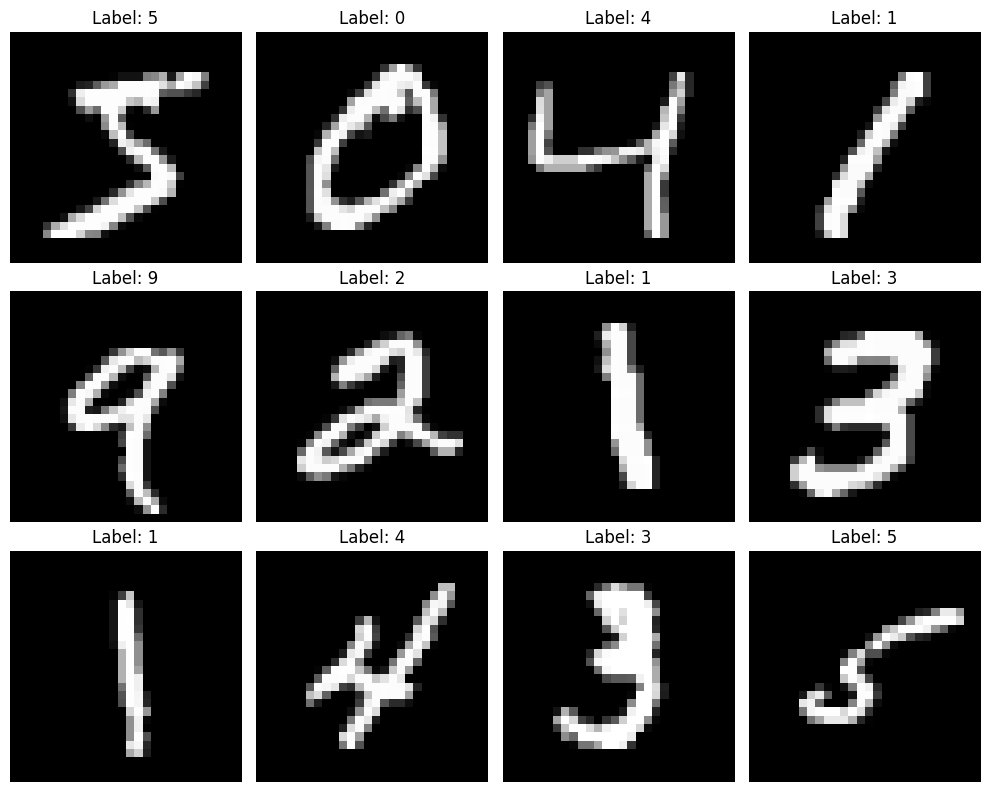

Train Epoch: 1 [6336/60000 (11%)]	Loss: 2.1992
Train Epoch: 1 [12736/60000 (21%)]	Loss: 1.7129
Train Epoch: 1 [19136/60000 (32%)]	Loss: 1.2892
Train Epoch: 1 [25536/60000 (43%)]	Loss: 1.0090
Train Epoch: 1 [31936/60000 (53%)]	Loss: 0.8274
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.7472
Train Epoch: 1 [44736/60000 (75%)]	Loss: 0.6736
Train Epoch: 1 [51136/60000 (85%)]	Loss: 0.6416
Train Epoch: 1 [57536/60000 (96%)]	Loss: 0.5887

Train Accuracy: 40111/60000 (66.9%)

Test set: Average loss: 0.5431, Accuracy: 8463/10000 (84.6%)

Train Epoch: 2 [6336/60000 (11%)]	Loss: 0.5483
Train Epoch: 2 [12736/60000 (21%)]	Loss: 0.5185
Train Epoch: 2 [19136/60000 (32%)]	Loss: 0.4907
Train Epoch: 2 [25536/60000 (43%)]	Loss: 0.4768
Train Epoch: 2 [31936/60000 (53%)]	Loss: 0.5052
Train Epoch: 2 [38336/60000 (64%)]	Loss: 0.4635
Train Epoch: 2 [44736/60000 (75%)]	Loss: 0.4352
Train Epoch: 2 [51136/60000 (85%)]	Loss: 0.4249
Train Epoch: 2 [57536/60000 (96%)]	Loss: 0.4248

Train Accuracy: 51974/60000 (86.6%)



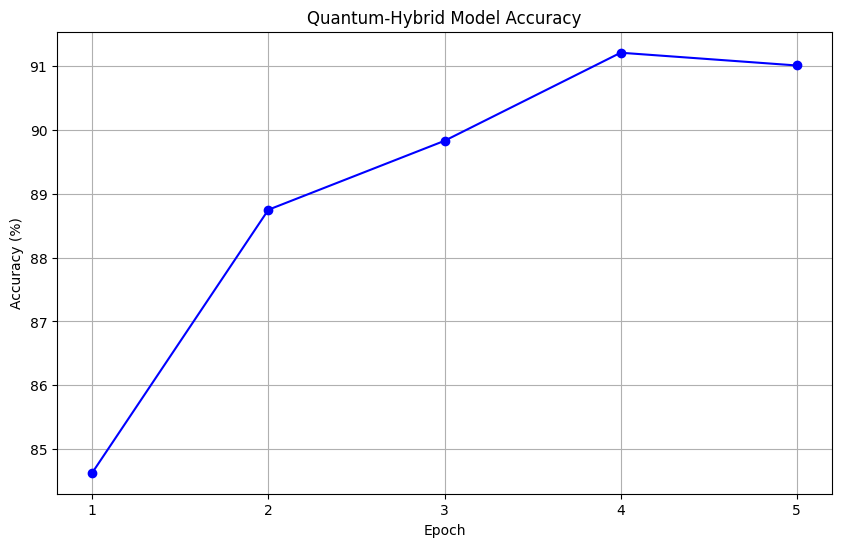

In [3]:
import torch
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# 超参数设置 ----------------------------------------------------------------------------
batch_size = 64
learning_rate = 0.005    # 降低学习率
epochs = 5               # 减少训练轮次（量子训练较慢）
n_qubits = 4             # 量子比特数量
n_qlayers = 2            # 量子电路层数

# 量子设备配置 --------------------------------------------------------------------------
dev = qml.device("default.qubit", wires=n_qubits)  # 使用默认量子模拟器

# 量子电路定义 --------------------------------------------------------------------------
@qml.qnode(dev, interface="torch")
def quantum_layer(inputs, weights):
    # 数据编码：将经典数据映射到量子态
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # 可训练量子操作
    for layer in range(n_qlayers):
        # 单量子比特旋转
        for qubit in range(n_qubits):
            qml.Rot(*weights[layer, qubit], wires=qubit)

        # 纠缠层
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit+1])

    # 测量操作
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# 数据预处理 ---------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((14, 14)),        # 缩小图像尺寸
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载数据集 ---------------------------------------------------------------------------
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,        # 自动下载数据集
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 可视化数据集样本 ----------------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(train_dataset.data[i], cmap='gray')
    plt.title(f"Label: {train_dataset.targets[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 混合量子-经典模型定义 ----------------------------------------------------------------
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 经典卷积部分
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=3),  # 减小通道数
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(8, 16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        # 量子部分
        self.quantum_layer = qml.qnn.TorchLayer(
            quantum_layer,
            weight_shapes={"weights": (n_qlayers, n_qubits, 3)}
        )

        # 全连接层
        self.fc = torch.nn.Linear(n_qubits, 10)  # 量子输出到10个类别

    def forward(self, x):
        # 经典特征提取
        x = self.conv_block(x)
        batch_size = x.shape[0]

        # 展平并降维到量子比特数
        x = x.view(batch_size, -1)
        x = torch.nn.functional.adaptive_avg_pool1d(x, n_qubits)  # 动态适应维度

        # 量子计算
        x = self.quantum_layer(x.squeeze())

        # 分类输出
        return self.fc(x)

# 初始化模型、损失函数和优化器 ----------------------------------------------------------
model = HybridModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 使用Adam优化器

# 训练函数 ----------------------------------------------------------------------------
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

        if batch_idx % 100 == 99:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]'
                  f'\tLoss: {total_loss / 100:.4f}')
            total_loss = 0

    print(f'\nTrain Accuracy: {correct}/{len(train_loader.dataset)}'
          f' ({100. * correct / len(train_loader.dataset):.1f}%)\n')

# 测试函数 ----------------------------------------------------------------------------
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test set: Average loss: {test_loss:.4f},'
          f' Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.1f}%)\n')
    return accuracy

# 主训练循环 --------------------------------------------------------------------------
if __name__ == '__main__':
    acc_history = []
    for epoch in range(1, epochs + 1):
        train(epoch)
        acc = test()
        acc_history.append(acc)

    # 绘制准确率曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), acc_history, 'b-o')
    plt.title("Quantum-Hybrid Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.xticks(range(1, epochs+1))
    plt.show()

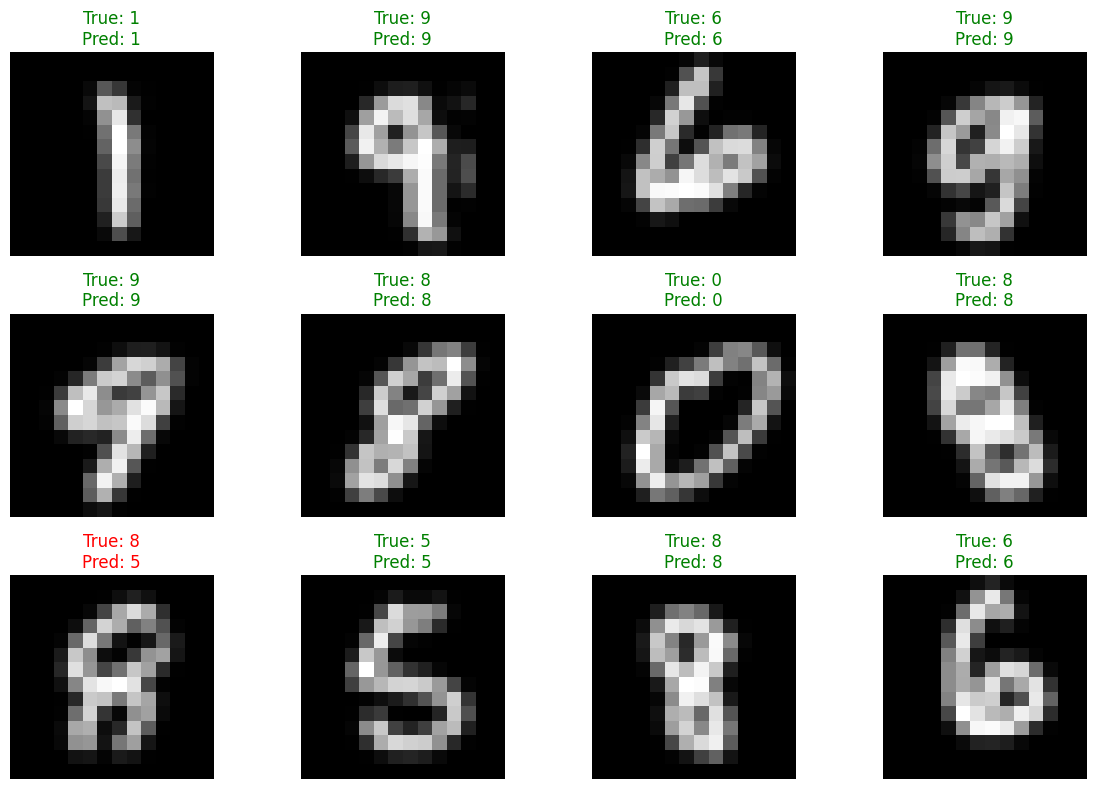


这批样本的识别准确率: 11/12 (91.7%)


In [5]:
import random
import numpy as np

# 设置随机种子以保证可重复性
# random.seed(42)
# np.random.seed(42)

# 从测试集中随机选择12个样本
num_samples = 12
random_indices = random.sample(range(len(test_dataset)), num_samples)
sample_images = [test_dataset[i][0].unsqueeze(0) for i in random_indices]
sample_labels = [test_dataset[i][1] for i in random_indices]

# 将样本堆叠成一个batch
sample_batch = torch.cat(sample_images)

# 使用模型进行预测
model.eval()
with torch.no_grad():
    predictions = model(sample_batch)
    predicted_labels = predictions.argmax(dim=1).numpy()

# 可视化结果
plt.figure(figsize=(12, 8))
for i in range(num_samples):
    plt.subplot(3, 4, i+1)
    image = sample_images[i].squeeze().numpy()  # 去除批次维度并转为numpy数组

    # 反归一化以便正确显示图像
    image = image * 0.3081 + 0.1307  # 使用MNIST的标准化参数
    plt.imshow(image, cmap='gray')

    # 显示真实标签和预测标签
    true_label = sample_labels[i]
    pred_label = predicted_labels[i]

    # 用不同颜色标记正确和错误预测
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 计算这批样本的准确率
correct = sum(1 for true, pred in zip(sample_labels, predicted_labels) if true == pred)
print(f"\n这批样本的识别准确率: {correct}/{num_samples} ({100.*correct/num_samples:.1f}%)")

In [6]:
# prompt: 保存模型到谷歌云盘

from google.colab import drive
drive.mount('/content/drive')

# 保存模型到 Google Drive
model_path = '/content/drive/My Drive/quantum_mnist_model.pth'  # 修改为你想要的路径
torch.save(model.state_dict(), model_path)
print(f"模型已保存到: {model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
模型已保存到: /content/drive/My Drive/quantum_mnist_model.pth
